# Training a GRU model using the basic negation data (version 1)


## Here we will use the GRU model to distinguish between to kind of sentences:

- 1) A, not A (contradiction)

- 2) not A, A (contradiction)

- 3) A, not B (non-contradiction)

- 4) not B, A (non-contradiction)




In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
import math
from torchtext import data
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.parameter import Parameter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
train_data.head()

,sentence1,sentence2,label
0,Brooke is not helpful,Brooke is helpful,1
1,Boo is not clever,Boo is clever,1
2,Doe is not poor,Doe is poor,1
3,Hodgson is ambitious,Hodgson is not ambitious,1
4,Hobbes is proud,Marston is not easy,0


In [4]:
test_data.head()

,sentence1,sentence2,label
0,Oakley is brave,Oakley is not brave,1
1,Jean is not alive,Jean is alive,1
2,Starlit is proud,Starlit is not proud,1
3,Temple is not delightful,Westcott is wrong,0
4,Jazz is jolly,Jazz is not jolly,1


## Putting the sentences together

In [5]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [6]:
train_data.head()

,text,label
0,"Brooke is not helpful, Brooke is helpful",1
1,"Boo is not clever, Boo is clever",1
2,"Doe is not poor, Doe is poor",1
3,"Hodgson is ambitious, Hodgson is not ambitious",1
4,"Hobbes is proud, Marston is not easy",0


In [7]:
test_data.head()

,text,label
0,"Oakley is brave, Oakley is not brave",1
1,"Jean is not alive, Jean is alive",1
2,"Starlit is proud, Starlit is not proud",1
3,"Temple is not delightful, Westcott is wrong",0
4,"Jazz is jolly, Jazz is not jolly",1


In [8]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

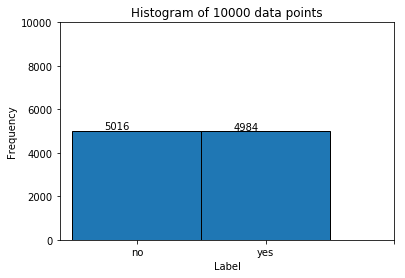

In [9]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

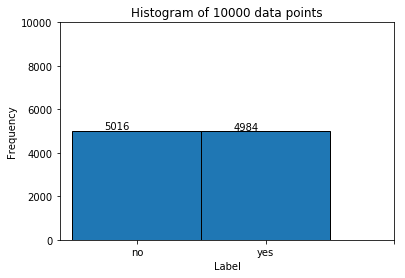

In [10]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [11]:
print("\n=== AFTER using the function simple_pre_process_text_df ===\n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


=== AFTER using the function simple_pre_process_text_df ===

doe is not poor doe is poor

hodgson is ambitious hodgson is not ambitious

hobbes is proud marston is not easy


## Saving the new version of the data in a csv

In [12]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

### Starting with torch

We use the `data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [13]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [14]:
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path=test_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [15]:
train, valid = train.split(0.8)

In [16]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 8000
len(valid): 2000
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [17]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [18]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1358
len(LABEL.vocab): 2


Printing the 20 most frequent words

In [19]:
print(TEXT.vocab.freqs.most_common(20))

[('is', 16000), ('not', 8000), ('inexpensive', 377), ('faithful', 376), ('thankful', 375), ('eager', 374), ('mealy', 371), ('zealous', 370), ('odd', 369), ('happy', 369), ('better', 366), ('kind', 366), ('witty', 365), ('clever', 365), ('brave', 364), ('gentle', 360), ('proud', 359), ('victorious', 353), ('obedient', 348), ('polite', 347)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [20]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
is 2
not 3
inexpensive 4
faithful 5
thankful 6
eager 7
mealy 8
zealous 9

TEXT.vocab.stoi
word index
i 0
love 738
trump 0


In [21]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=100,
                 output_dim=2,
                 epochs=5,
                 learning_rate=0.05,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [22]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1358
batch_size = 32
embedding_dim = 100
rnn_dim = 100
output_dim = 2
epochs = 5
learning_rate = 0.05
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [23]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
b1data = DataHolder(config, train, valid, test) 

We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [24]:
batch = next(iter(b1data.train_iter))

print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))
print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))

batch_t = batch.text.transpose(0, 1)
for example in batch_t:
    print()
    print([TEXT.vocab.itos[i] for i in example], end=" ")

batch.text.shape = torch.Size([7, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor


['jamison', 'is', 'not', 'lively', 'charlie', 'is', 'vast'] 
['mead', 'is', 'not', 'calm', 'bruin', 'is', 'mushy'] 
['halsey', 'is', 'witty', 'halsey', 'is', 'not', 'witty'] 
['crawford', 'is', 'happy', 'temperance', 'is', 'not', 'powerful'] 
['branson', 'is', 'zealous', 'branson', 'is', 'not', 'zealous'] 
['royce', 'is', 'not', 'better', 'royce', 'is', 'better'] 
['fleming', 'is', 'gentle', 'scarlett', 'is', 'not', 'unimportant'] 
['upton', 'is', 'thankful', 'nayland', 'is', 'not', 'tender'] 
['ellington', 'is', 'ambitious', 'ellington', 'is', 'not', 'ambitious'] 
['hopper', 'is', 'silly', 'rigby', 'is', 'not', 'wrong'] 
['sinjon', 'is', 'not', 'unimportant', 'sinjon', 'is', 'unimportant'] 
['pistol', 'is', 'not', 'better', 'pistol', 'is', 'better'] 
['pearce', 'is', 'not', 'eager', 'mortimer', 'is', 'important'] 
['easton', 'is', 'not'

## Defining an new version of the LSTM to acces the model's gates

In [31]:
def LSTMCellExposed(input_tensor, hidden, w_ih, w_hh, b_ih=None, b_hh=None):

    hx, cx = hidden
    gates = F.linear(input_tensor, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)

    cy = (forgetgate * cx) + (ingate * cellgate)
    hy = outgate * F.tanh(cy)

    return hy, cy, ingate, forgetgate, cellgate, outgate


class LSTMCell(nn.modules.rnn.RNNCellBase):
    r"""A long short-term memory (LSTM) cell.

    .. math::

        \begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
        \end{array}

    where :math:`\sigma` is the sigmoid function.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If `False`, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, (h_0, c_0)
        - **input** of shape `(batch, input_size)`: tensor containing input features
        - **h_0** of shape `(batch, hidden_size)`: tensor containing the initial hidden
          state for each element in the batch.
        - **c_0** of shape `(batch, hidden_size)`: tensor containing the initial cell state
          for each element in the batch.

          If `(h_0, c_0)` is not provided, both **h_0** and **c_0** default to zero.

    Outputs: h_1, c_1
        - **h_1** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch
        - **c_1** of shape `(batch, hidden_size)`: tensor containing the next cell state
          for each element in the batch

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(4*hidden_size x input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(4*hidden_size x hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(4*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(4*hidden_size)`

    Examples::

        >>> rnn = nn.LSTMCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> cx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
                hx, cx = rnn(input[i], (hx, cx))
                output.append(hx)
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        if bias:
            self.bias_ih = Parameter(torch.Tensor(4 * hidden_size))
            self.bias_hh = Parameter(torch.Tensor(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input, hx=None):
        self.check_forward_input(input)
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
        self.check_forward_hidden(input, hx[0], '[0]')
        self.check_forward_hidden(input, hx[1], '[1]')
        hy, cy, ingate, forgetgate, cellgate, outgate = LSTMCellExposed(input,
                                                                       hx,
                                                                       self.weight_ih,
                                                                       self.weight_hh,
                                                                       self.bias_ih,
                                                                       self.bias_hh)
        return hy, cy, ingate, forgetgate, cellgate, outgate
    

class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.LSTM_cell = LSTMCell(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):
        """
        Apply the model to the input x
        
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """        
        embedded = self.embedding(x)
        hx = torch.zeros((x.shape[1], config.rnn_dim))
        cx = torch.zeros((x.shape[1], config.rnn_dim))
        all_hidden = []
        in_gates = []
        forget_gates = []
        cell_gates = []
        out_gates = []
        for i in range(x.shape[0]):
            hx, cx, ingate, forgetgate, cellgate, outgate = self.LSTM_cell(embedded[i], (hx, cx))
            all_hidden.append(hx)
            in_gates.append(ingate)
            forget_gates.append(forgetgate)
            cell_gates.append(cellgate)
            out_gates.append(outgate)
            
        all_hidden = torch.stack(all_hidden)
        in_gates = torch.stack(in_gates)
        forget_gates = torch.stack(forget_gates)
        cell_gates = torch.stack(cell_gates)
        out_gates = torch.stack(out_gates)
            
        self.output = all_hidden
        hidden = all_hidden[-1,:,:]
        
        self.in_gates = in_gates
        self.forget_gates = forget_gates
        self.cell_gates = cell_gates
        self.out_gates = out_gates        
        
        out = self.fc(hidden)
        return out

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels

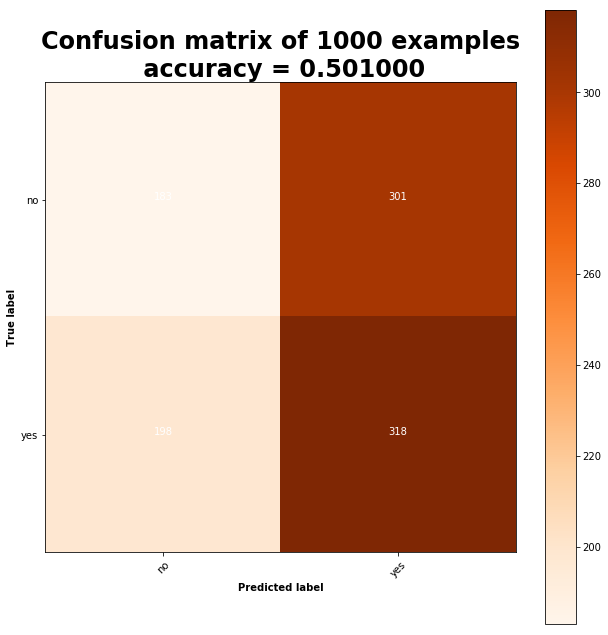

In [26]:
model = LSTM(config)

test_bach = next(iter(b1data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="lstm_confusion_matrix_b1.png",
                      classes=labels_legend)

## Training functions

In [27]:
def train_in_epoch(model, iterator, optimizer, criterion, negative=False):
    """
    Train the model using all the data from the iterator 

    :param model: RNN classification model
    :type model: RNN 
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: mean loss, mean accuracy
    :rtype: float, float    
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        if negative:
            loss = - loss
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    """
    Get the valid loss

    :param model: RNN classification model
    :type model: 
    :param valid_iter: valid iterator
    :type valid_iter: data.BucketIterator
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: valid loss
    :rtype: Tensor(shape=[])    
    """
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True, negative=False):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(config.epochs):

        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train_in_epoch(model, train_iter, optimizer, criterion, negative)
        all_train_loss.append(train_loss)
        valid_loss = get_valid_loss(model, valid_iter, criterion)
        all_valid_loss.append(valid_loss)

        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))

        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)

        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))

    if verbose:
        x = np.arange(1, len(all_train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, all_train_loss, label='mean train loss')
        ax.plot(x, all_valid_loss, label='mean valid loss')
        ax.legend()
        plt.xlabel('epoch')
        plt.ylabel('mean loss')
        plt.title('Train and valid mean loss')
        plt.grid(True)
        plt.show()

epoch = (1/5)

train_loss = 0.655 | valid_loss = 0.596
train_acc = 0.6395

epoch = (2/5)

train_loss = 0.527 | valid_loss = 0.509
train_acc = 0.73325

epoch = (3/5)

train_loss = 0.380 | valid_loss = 0.298
train_acc = 0.813875

epoch = (4/5)

train_loss = 0.127 | valid_loss = 0.033
train_acc = 0.971625

epoch = (5/5)

train_loss = 0.017 | valid_loss = 0.009
train_acc = 0.9995



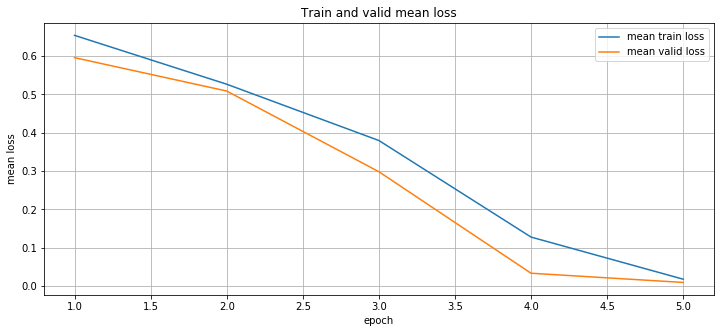

In [28]:
training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "lstm_v1.pkl")

## Looking at the model after training

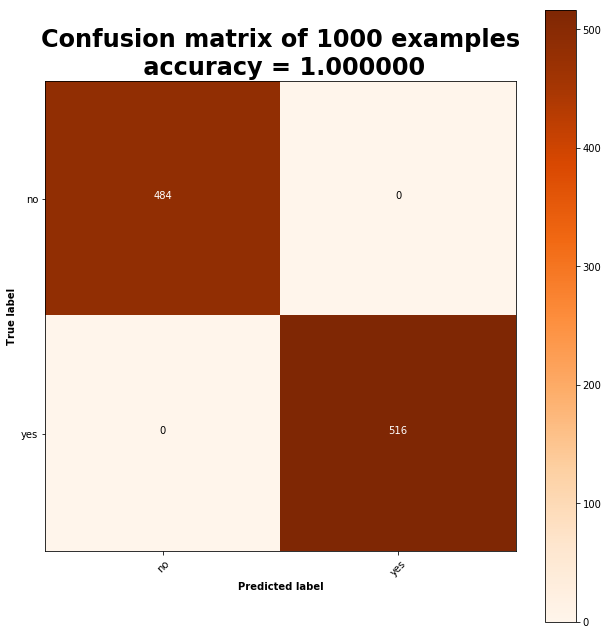

In [29]:
model = LSTM(config)
model.load_state_dict(torch.load('lstm_v1.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="lstm_confusion_matrix.png",
                      classes=labels_legend)

## Training the negative model (the model obtained by maximizing the CE error)

epoch = (1/5)

train_loss = -19.433 | valid_loss = 102.493
train_acc = 0.4995

epoch = (2/5)

train_loss = -311.604 | valid_loss = 631.391
train_acc = 0.497875

epoch = (3/5)

train_loss = -701.322 | valid_loss = 893.195
train_acc = 0.497875

epoch = (4/5)

train_loss = -1091.074 | valid_loss = 1361.388
train_acc = 0.497875

epoch = (5/5)

train_loss = -1480.827 | valid_loss = 1669.390
train_acc = 0.497875



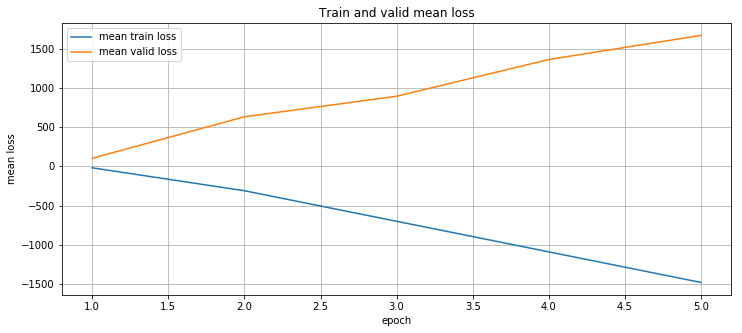

In [30]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   learning_rate=0.03,
                   momentum=0.02)

model = LSTM(config)

training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "lstm_v1_neg.pkl",
                                  negative=True)

# Adding visualization

## Analysis of single neurons and gates¶

We will now look at the individual activations of neurons in a Recurrent network. The functions bellow serve to print each sentence using one value of the hidden vector for each word.


In [34]:
def sentence_plot(sentences, values, title=None):
    """
    plot the values of one dimension of the hidden vector to
    each word in the sentence.

    :param sentences: sentences to be printed
    :type sentences: list of str 
    :param values: one dimension of the hidden vector 
                   for each word of the sentence
    :type values: np.array(shape=(num_sentences, sent_len))
    """
    assert len(sentences) == values.shape[0]
    for sentence in sentences:
        assert len(sentence.split()) == values.shape[1]

    all_values = []
    sentence_size = np.max([len(sentence) for sentence in sentences])
    for sid, sentence in enumerate(sentences):
        temp = np.zeros((sentence_size))
        count = 0
        for wid, word in enumerate(sentence.split()):
            temp[count: count + len(word)] = values[sid][wid]
            count = count + len(word) + 1
        all_values.append(temp)
    all_values = np.array(all_values)

    height = all_values.shape[0] 
    width = all_values.shape[1]
    
    plt.figure(figsize=(width * 1.6, height * 0.3))
    plt.title(title)
    plt.imshow(all_values, interpolation='none',
             cmap='Oranges')
    plt.axis('off')
    for sid, sentence in enumerate(sentences):
        for wid, word in enumerate(sentence):
            plt.text(wid-0.2,sid+0.2,word,color='k',fontsize=12)

    plt.show()
    plt.close()

def get_hidden_LSTM(sentences, model, mode=None):
    """
    get the hidden state for each word of each sentence,
    we use softmax to normalize the values of the hidden stater

    :param sentences: sentences
    :type sentences: list of str 
    :param model: LSTM type model
    :type values: LSTM
    :return: array with hidden states for each sentence
    :rtype: np.array
    """
    assert model._get_name() == "LSTM"
    all_hiddend_states = []
    all_in_gates = []
    all_forget_gates = []
    all_cell_gates = []
    all_out_gates = []
    all_text = []
    all_lists = [all_hiddend_states,
                 all_in_gates,
                 all_forget_gates,
                 all_cell_gates,
                 all_out_gates]
    pad = TEXT.vocab.stoi["<pad>"]
    max_size = np.max([len(sentence.split()) for sentence in sentences])
    softmax = torch.nn.Softmax(dim=2)
    sig = torch.nn.Sigmoid()
    for example in sentences:
        text = simple_pre_process_text(example)
        text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
        if len(text_as_int) < max_size:
            text_as_int += [pad] * (max_size - len(text_as_int))
        padded_text = [TEXT.vocab.itos[word] for word in text_as_int]
        padded_text = " ".join(padded_text)
        all_text.append(padded_text)
        text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
        text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
        text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
        _ = model.predict(text_as_tensor)

        states = model.output
        in_gates = model.in_gates
        forget_gates = model.forget_gates
        cell_gates = model.cell_gates
        out_gates = model.out_gates

        if mode == "softmax":
            states = softmax(states)
            in_gates = softmax(in_gates)
            forget_gates = softmax(forget_gates)
            cell_gates = softmax(cell_gates)
            out_gates = softmax(out_gates)
            
        elif mode == "sigmoid":
            states = sig(states)
            in_gates = sig(in_gates)
            forget_gates = sig(forget_gates)
            cell_gates = sig(cell_gates)
            out_gates = sig(out_gates)

        for i, tensor in enumerate([states, in_gates, forget_gates, cell_gates, out_gates]): 
            tensor = tensor.detach().numpy()
            tensor = tensor.reshape(max_size, config.rnn_dim)
            all_lists[i].append(tensor)
    return np.array(all_lists[0]), np.array(all_lists[1]), np.array(all_lists[2]), np.array(all_lists[3]), np.array(all_lists[4]), all_text 

## Getting the hidden states from 10 sentences with contradiction and from 10 sentences without contradiction

In [35]:
df_test_contra = test_data[test_data["label"]==1]
df_test_non_contra = test_data[test_data["label"]==0]
test_sentences_contra =  df_test_contra["text"].values
test_sentences_non_contra =  df_test_non_contra["text"].values

np.random.shuffle(test_sentences_contra)
np.random.shuffle(test_sentences_non_contra)

some_test_sentences_contra = test_sentences_contra[0:10]
some_test_sentences_non_contra = test_sentences_non_contra[0:10]
some_sentences = list(some_test_sentences_contra) + list(some_test_sentences_non_contra)
np.random.shuffle(some_sentences)

states_contra, in_gates_contra, forget_gates_contra, cell_gates_contra, out_gates_contra, some_test_sentences_contra_pad = get_hidden_LSTM(some_test_sentences_contra,
                                                                                                                                           model)

states_non_contra, in_gates_non_contra, forget_gates_non_contra, cell_gates_non_contra, out_gates_non_contra, some_test_sentences_non_contra_pad = get_hidden_LSTM(some_test_sentences_non_contra,
                                                                                                                                                                   model)

## Here we will visualize the intensity of a random neuron for each word for each sentence.

### First, only the contradictory sentences

- ### Hidden states

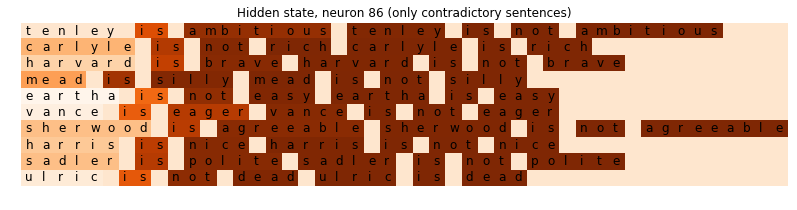

In [36]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              states_contra[:, :, neuron_id],
              title="Hidden state, neuron {} (only contradictory sentences)".format(neuron_id))

- ### Input gates

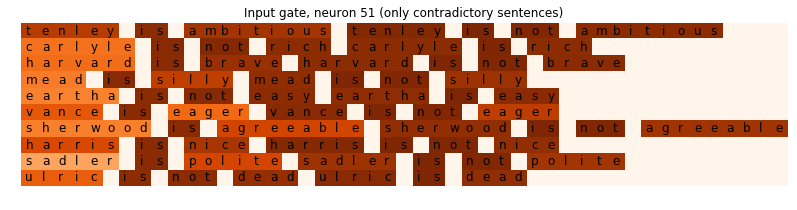

In [37]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              in_gates_contra[:, :, neuron_id],
              title="Input gate, neuron {} (only contradictory sentences)".format(neuron_id))

- ### Forget gate

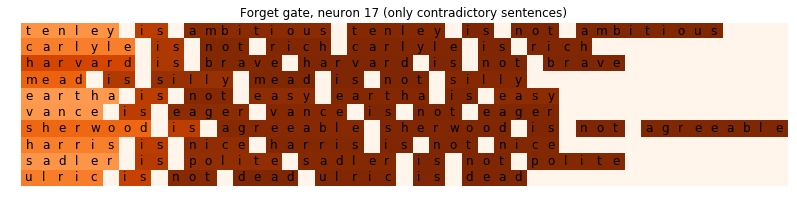

In [38]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              forget_gates_contra[:, :, neuron_id],
              title="Forget gate, neuron {} (only contradictory sentences)".format(neuron_id))

- ### Cell gates

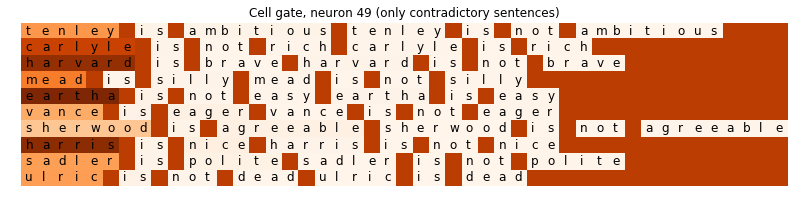

In [39]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              cell_gates_contra[:, :, neuron_id],
              title="Cell gate, neuron {} (only contradictory sentences)".format(neuron_id))

- ### Output gates

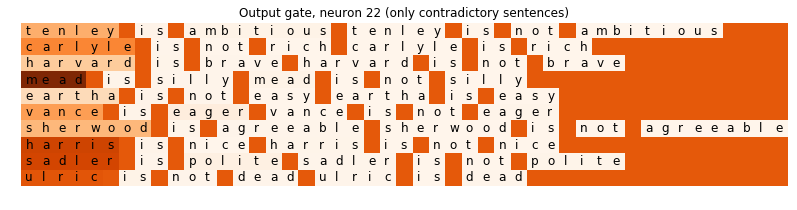

In [40]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_contra_pad,
              out_gates_contra[:, :, neuron_id],
              title="Output gate, neuron {} (only contradictory sentences)".format(neuron_id))



### Second, visualization examples for the non contradictory sentences

- ### Hidden states

In [ ]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra[:, :, neuron_id],
              title="Hidden state, neuron {} (only non contradictory sentences)".format(neuron_id))

- ### Reset gates

In [ ]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra[:, :, neuron_id],
              title="Reset gate, neuron {} (only non contradictory sentences)".format(neuron_id))

- ### Update gate

In [ ]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra[:, :, neuron_id],
              title="Update gate, neuron {} (only non contradictory sentences)".format(neuron_id))

- ### New candidate for hidden state

In [ ]:
neuron_id = np.random.randint(0, config.rnn_dim)

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra[:, :, neuron_id],
              title="New candidate, neuron {} (only non contradictory sentences)".format(neuron_id))

##  What kind of neurons can we expect to find?

- Negation neuron - activates around negation names of people in the play, such as Ralph, Lenora, Alton, etc.
- Same adjective neuron - activates when the same adjective comes around
- Same name neuron - activates when the same name comes around

This kind of visualization is useful, but remember:

> Note, that if neurons like these do not appear it does not mean that network does not "know" these elements. Highly discriminative, single neuron decoupling is not something neural networks are trained to do, it is just an empirical observation, shared across many domains (cat neurons in visual classifiers etc.). Knowledge can be represented in many other ways, in particular the fact that it is represented in a single neuron does not mean network does not have a distributed "backup" of the same knowledge somewhere else.


## We can also use the hidden state to create a picture as follows:

`sentences = [i like you, you like me]`

`picture = [emb(i), emb(i like), emb(i like you), emb(you), emb(you like), emb(you like me)]`

`picture.shape = (2*3, emb_size)`

where `emb(s)` is the RNN embedding version of the sentence `s` (of size `emb_size`)

In [ ]:
def state2picture(state_contra, state_non_contra, title="picture"):
    new_shape = (state_contra.shape[0] * state_contra.shape[1], state_contra.shape[2])
    picture1 = state_contra.reshape(new_shape)
    picture2 = state_non_contra.reshape(new_shape)
    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    for i, ax in enumerate(axes.flat):
        if i % 2 == 0:
            picture = picture1
            ax.set_title(title + "contradictions only")
        else:
            picture = picture2
            ax.set_title(title + "non-contradictions only")
        ax.imshow(picture.T)
    plt.show()


In [ ]:
model = GRU(config)

states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)
state2picture(states_contra, states_non_contra, title="(hidden states) non-trained: ")
state2picture(resets_contra, resets_non_contra, title="(reset gates) non-trained: ")
state2picture(updates_contra, updates_non_contra, title="(updates states) non-trained: ")
state2picture(news_contra, news_non_contra, title="(new candidate) non-trained: ")


In [ ]:
model = GRU(config)
model.load_state_dict(torch.load('gru_v1.pkl'))


states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)
state2picture(states_contra, states_non_contra, title="(hidden states) trained: ")
state2picture(resets_contra, resets_non_contra, title="(reset gates) trained: ")
state2picture(updates_contra, updates_non_contra, title="(updates states) trained: ")
state2picture(news_contra, news_non_contra, title="(new candidate) trained: ")


In [ ]:
model = GRU(config)
model.load_state_dict(torch.load('gru_v1_neg.pkl'))


states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)
state2picture(states_contra, states_non_contra, title="(hidden states) negative model: ")
state2picture(resets_contra, resets_non_contra, title="(reset gates) negative model: ")
state2picture(updates_contra, updates_non_contra, title="(updates states) negative model: ")
state2picture(news_contra, news_non_contra, title="(new candidate) negative model: ")

## Analysis of the state dynamics

Here, we will visualize the activations in a different way, by projecting them to ** 3 dimensions**, via dimensionality reduction.

In [ ]:
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}

projector = projector_fun(n_components=3, **kwargs[projector])

## Before training

In [ ]:
model = GRU(config)

states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)

states_contra3d = []
resets_contra3d = []
updates_contra3d = []
news_contra3d = []


for i in range(states_contra.shape[0]):
    states_contra3d.append(projector.fit_transform(states_contra[i]))
    resets_contra3d.append(projector.fit_transform(resets_contra[i]))
    updates_contra3d.append(projector.fit_transform(updates_contra[i]))
    news_contra3d.append(projector.fit_transform(news_contra[i]))
    
    
states_contra3d = np.array(states_contra3d)
resets_contra3d = np.array(resets_contra3d)
updates_contra3d = np.array(updates_contra3d)
news_contra3d = np.array(news_contra3d)


states_non_contra3d = []
resets_non_contra3d = []
updates_non_contra3d = []
news_non_contra3d = []
for i in range(states_non_contra.shape[0]):
    states_non_contra3d.append(projector.fit_transform(states_non_contra[i]))
    resets_non_contra3d.append(projector.fit_transform(resets_non_contra[i]))
    updates_non_contra3d.append(projector.fit_transform(updates_non_contra[i]))
    news_non_contra3d.append(projector.fit_transform(news_non_contra[i]))

states_non_contra3d = np.array(states_non_contra3d)
resets_non_contra3d = np.array(resets_non_contra3d)
updates_non_contra3d = np.array(updates_non_contra3d)
news_non_contra3d = np.array(news_non_contra3d)


#### Visualizing the projected vectors using PCA: **only contradictions**

In [ ]:
sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 0],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 1],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 2],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(2))

#### Visualizing the projected vectors using PCA: **only non contradictions**

In [ ]:
sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 0],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(2))


## After training

In [ ]:
model = GRU(config)

model.load_state_dict(torch.load('gru_v1.pkl'))



states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)

states_contra3d = []
resets_contra3d = []
updates_contra3d = []
news_contra3d = []


for i in range(states_contra.shape[0]):
    states_contra3d.append(projector.fit_transform(states_contra[i]))
    resets_contra3d.append(projector.fit_transform(resets_contra[i]))
    updates_contra3d.append(projector.fit_transform(updates_contra[i]))
    news_contra3d.append(projector.fit_transform(news_contra[i]))
    
    
states_contra3d = np.array(states_contra3d)
resets_contra3d = np.array(resets_contra3d)
updates_contra3d = np.array(updates_contra3d)
news_contra3d = np.array(news_contra3d)


states_non_contra3d = []
resets_non_contra3d = []
updates_non_contra3d = []
news_non_contra3d = []
for i in range(states_non_contra.shape[0]):
    states_non_contra3d.append(projector.fit_transform(states_non_contra[i]))
    resets_non_contra3d.append(projector.fit_transform(resets_non_contra[i]))
    updates_non_contra3d.append(projector.fit_transform(updates_non_contra[i]))
    news_non_contra3d.append(projector.fit_transform(news_non_contra[i]))

states_non_contra3d = np.array(states_non_contra3d)
resets_non_contra3d = np.array(resets_non_contra3d)
updates_non_contra3d = np.array(updates_non_contra3d)
news_non_contra3d = np.array(news_non_contra3d)


#### Visualizing the projected vectors using PCA: **only contradictions**

In [ ]:
sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 0],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 1],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 2],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(2))

#### Visualizing the projected vectors using PCA: **only non contradictions**

In [ ]:
sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 0],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(2))


## Negative model

In [ ]:
model = GRU(config)

model.load_state_dict(torch.load('gru_v1_neg.pkl'))

states_contra, resets_contra, updates_contra, news_contra, some_test_sentences_contra_pad = get_hidden_GRU(some_test_sentences_contra,
                                                                                                           model)

states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, some_test_sentences_non_contra_pad = get_hidden_GRU(some_test_sentences_non_contra,
                                                                                                                               model)

states_contra3d = []
resets_contra3d = []
updates_contra3d = []
news_contra3d = []


for i in range(states_contra.shape[0]):
    states_contra3d.append(projector.fit_transform(states_contra[i]))
    resets_contra3d.append(projector.fit_transform(resets_contra[i]))
    updates_contra3d.append(projector.fit_transform(updates_contra[i]))
    news_contra3d.append(projector.fit_transform(news_contra[i]))
    
    
states_contra3d = np.array(states_contra3d)
resets_contra3d = np.array(resets_contra3d)
updates_contra3d = np.array(updates_contra3d)
news_contra3d = np.array(news_contra3d)


states_non_contra3d = []
resets_non_contra3d = []
updates_non_contra3d = []
news_non_contra3d = []
for i in range(states_non_contra.shape[0]):
    states_non_contra3d.append(projector.fit_transform(states_non_contra[i]))
    resets_non_contra3d.append(projector.fit_transform(resets_non_contra[i]))
    updates_non_contra3d.append(projector.fit_transform(updates_non_contra[i]))
    news_non_contra3d.append(projector.fit_transform(news_non_contra[i]))

states_non_contra3d = np.array(states_non_contra3d)
resets_non_contra3d = np.array(resets_non_contra3d)
updates_non_contra3d = np.array(updates_non_contra3d)
news_non_contra3d = np.array(news_non_contra3d)


#### Visualizing the projected vectors using PCA: **only contradictions**

In [ ]:
sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              states_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              resets_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              updates_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only contradictory sentences)".format(2))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 0],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(0))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 1],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(1))

sentence_plot(some_test_sentences_contra_pad,
              news_contra3d[:, :, 2],
              title="PCA - candidate vector, neuron {} (only contradictory sentences)".format(2))

#### Visualizing the projected vectors using PCA: **only non contradictions**

In [ ]:
sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 0],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 1],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              states_non_contra3d[:, :, 2],
              title="PCA - hidden state, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 0],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 1],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              resets_non_contra3d[:, :, 2],
              title="PCA - reset gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 0],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 1],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              updates_non_contra3d[:, :, 2],
              title="PCA - update gate, neuron {} (only non contradictory sentences)".format(2))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 0],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(0))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(1))

sentence_plot(some_test_sentences_non_contra_pad,
              news_non_contra3d[:, :, 1],
              title="PCA -  - candidate vector, neuron {} (only non contradictory sentences)".format(2))


##  Plotting the 2d representation of different sentences separated by class

In [ ]:
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}
projector = projector_fun(n_components=2, **kwargs[projector])

np.random.shuffle(test_sentences_contra)
np.random.shuffle(test_sentences_non_contra)

bunch_test_sentences_contra = test_sentences_contra[0:5000]
bunch_test_sentences_non_contra = test_sentences_non_contra[0:5000]


## Before Training

In [ ]:
model = GRU(config)
states_contra, resets_contra, updates_contra, news_contra, _ = get_hidden_GRU(bunch_test_sentences_contra,
                                                                              model)
states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, _ = get_hidden_GRU(bunch_test_sentences_non_contra,
                                                                                              model)

bunch_hiddend_states_contra2d = []
for state in states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
for state in states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (before training)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="gru_confusion_matrix_b1_v1.png",
                      classes=labels_legend)


## After Training

In [ ]:
model = GRU(config)

model.load_state_dict(torch.load('gru_v1.pkl'))

states_contra, resets_contra, updates_contra, news_contra, _ = get_hidden_GRU(bunch_test_sentences_contra,
                                                                              model)
states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, _ = get_hidden_GRU(bunch_test_sentences_non_contra,
                                                                                              model)

bunch_hiddend_states_contra2d = []
for state in states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
for state in states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (after training)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="gru_confusion_matrix_b1_v1.png",
                      classes=labels_legend)



## Negative model

In [ ]:
model = GRU(config)

model.load_state_dict(torch.load('gru_v1_neg.pkl'))

states_contra, resets_contra, updates_contra, news_contra, _ = get_hidden_GRU(bunch_test_sentences_contra,
                                                                              model)
states_non_contra, resets_non_contra, updates_non_contra, news_non_contra, _ = get_hidden_GRU(bunch_test_sentences_non_contra,
                                                                                              model)

bunch_hiddend_states_contra2d = []
for state in states_contra:
    bunch_hiddend_states_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_contra2d = np.array(bunch_hiddend_states_contra2d)


bunch_hiddend_states_non_contra2d = []
for state in states_non_contra:
    bunch_hiddend_states_non_contra2d.append(projector.fit_transform(state))

bunch_hiddend_states_non_contra2d = np.array(bunch_hiddend_states_non_contra2d)

all_x_contra = bunch_hiddend_states_contra2d[:,-1,0].flatten()
all_y_contra = bunch_hiddend_states_contra2d[:,-1,1].flatten()

all_x_non = bunch_hiddend_states_non_contra2d[:,-1,0].flatten()
all_y_non = bunch_hiddend_states_non_contra2d[:,-1,1].flatten()

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(all_x_contra, all_y_contra, marker='o',cmap=plt.get_cmap('Spectral'), label="contradictions")
ax.scatter(all_x_non, all_y_non, marker='x',cmap=plt.get_cmap('Spectral'), label="non contradictions")

ax.legend()
plt.title("2d representation of different sentences (negative model)".format(),
          fontsize=14,
          fontweight='bold')
plt.show()

_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="gru_confusion_matrix_b1_v1.png",
                      classes=labels_legend)


